# Developing an AI application

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import torch
from PIL import Image
import matplotlib.gridspec as gridspec
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from collections import OrderedDict
import json

## Load the data
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
data_transforms = {
    'training' : transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]),
                                                            
    'validation' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]),

    'testing' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
}


# TODO: Load the datasets with ImageFolder
image_datasets = {
    'training' : datasets.ImageFolder(train_dir, transform=data_transforms['training']),
    'testing' : datasets.ImageFolder(test_dir, transform=data_transforms['testing']),
    'validation' : datasets.ImageFolder(valid_dir, transform=data_transforms['validation'])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'training' : torch.utils.data.DataLoader(image_datasets['training'], batch_size=64, shuffle=True),
    'testing' : torch.utils.data.DataLoader(image_datasets['testing'], batch_size=64, shuffle=False),
    'validation' : torch.utils.data.DataLoader(image_datasets['validation'], batch_size=64, shuffle=True)
}

class_to_idx = image_datasets['training'].class_to_idx

### Label mapping

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

In [6]:
# TODO: Build and train your network
def get_model():
    model = models.densenet121(pretrained=True)
    return model

def build_model(hidden_layers, class_to_idx):
    model = get_model()
    for param in model.parameters():
        param.requires_grad = False
    
    classifier_input_size = model.classifier.in_features
    print("Input size: ", classifier_input_size)
    output_size = 102

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(classifier_input_size, hidden_layers)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(hidden_layers, output_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    
    model.classifier = classifier
    model.class_to_idx = class_to_idx
    return model

In [7]:
hidden_layers = 512
model = build_model(hidden_layers, class_to_idx)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth

100%|██████████| 32342954/32342954 [00:00<00:00, 57379292.76it/s]


Input size:  1024


In [8]:
def train(model, epochs, learning_rate, criterion, optimizer, training_loader, validation_loader):
    
    model.train()
    print_every = 40
    steps = 0
    use_gpu = False
    
    if torch.cuda.is_available():
        use_gpu = True
        model.cuda()
    else:
        model.cpu()

    for epoch in range(epochs):
        running_loss = 0
        for inputs, labels in iter(training_loader):
            steps += 1

            if use_gpu:
                inputs = Variable(inputs.float().cuda())
                labels = Variable(labels.long().cuda()) 
            else:
                inputs = Variable(inputs)
                labels = Variable(labels) 

            optimizer.zero_grad()
            output = model.forward(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]

            if steps % print_every == 0:
                validation_loss, accuracy = validate(model, criterion, validation_loader)

                print("Epoch: {}/{} ".format(epoch+1, epochs),
                        "Training Loss: {:.3f} ".format(running_loss/print_every),
                        "Validation Loss: {:.3f} ".format(validation_loss),
                        "Validation Accuracy: {:.3f}".format(accuracy))

In [9]:
def validate(model, criterion, data_loader):
    model.eval()
    accuracy = 0
    test_loss = 0
    
    for inputs, labels in iter(data_loader):
        if torch.cuda.is_available():
            inputs = Variable(inputs.float().cuda(), volatile=True)
            labels = Variable(labels.long().cuda(), volatile=True) 
        else:
            inputs = Variable(inputs, volatile=True)
            labels = Variable(labels, volatile=True)

        output = model.forward(inputs)
        test_loss += criterion(output, labels).data[0]
        ps = torch.exp(output).data 
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss/len(data_loader), accuracy/len(data_loader)

In [10]:
epochs = 9
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
train(model, epochs, learning_rate, criterion, optimizer, dataloaders['training'], dataloaders['validation'])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.

  

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.

  if __name__ == '__main__':

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number

  from ipykernel import kernelapp as app


Epoch: 1/9  Training Loss: 4.058  Validation Loss: 3.302  Validation Accuracy: 0.283

Epoch: 1/9  Training Loss: 6.761  Validation Loss: 1.948  Validation Accuracy: 0.606

Epoch: 2/9  Training Loss: 0.657  Validation Loss: 1.356  Validation Accuracy: 0.673

Epoch: 2/9  Training Loss: 1.999  Validation Loss: 1.075  Validation Accuracy: 0.749

Epoch: 2/9  Training Loss: 3.117  Validation Loss: 0.880  Validation Accuracy: 0.791

Epoch: 3/9  Training Loss: 0.809  Validation Loss: 0.767  Validation Accuracy: 0.808

Epoch: 3/9  Training Loss: 1.615  Validation Loss: 0.703  Validation Accuracy: 0.808

Epoch: 4/9  Training Loss: 0.197  Validation Loss: 0.561  Validation Accuracy: 0.868

Epoch: 4/9  Training Loss: 0.918  Validation Loss: 0.610  Validation Accuracy: 0.830

Epoch: 4/9  Training Loss: 1.628  Validation Loss: 0.629  Validation Accuracy: 0.835

Epoch: 5/9  Training Loss: 0.475  Validation Loss: 0.490  Validation Accuracy: 0.863

Epoch: 5/9  Training Loss: 1.138  Validation Loss: 0.4

## Testing your network

In [11]:
test_loss, accuracy = validate(model, criterion, dataloaders['testing'])
print("Val. Accuracy: {:.3f}".format(accuracy))
print("Val. Loss: {:.3f}".format(test_loss))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.

  

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.

  if __name__ == '__main__':

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number

  from ipykernel import kernelapp as app


Val. Accuracy: 0.882

Val. Loss: 0.439


## Save the checkpoint

In [12]:
# TODO: Save the checkpoint 
checkpoint_path = 'densenet121_checkpoint.pth'

state = {
    'arch': 'densenet121',
    'learning_rate': learning_rate,
    'hidden_layers': hidden_layers,
    'epochs': epochs,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'class_to_idx' : model.class_to_idx
}

torch.save(state, checkpoint_path)

## Loading the checkpoint

In [13]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
checkpoint_path = 'densenet121_checkpoint.pth'
state = torch.load(checkpoint_path)
learning_rate = state['learning_rate']
class_to_idx = state['class_to_idx']

model = build_model(hidden_layers, class_to_idx)

model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

print("Loaded '{}' (arch={}, hidden_layers={}, epochs={})".format(
    checkpoint_path, 
    state['arch'], 
    state['hidden_layers'], 
    state['epochs']))

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Input size:  1024

Loaded 'densenet121_checkpoint.pth' (arch=densenet121, hidden_layers=512, epochs=9)


# Inference for classification & Image Preprocessing

In [14]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    size = 224
    # TODO: Process a PIL image for use in a PyTorch model
    width, height = image.size
    
    if height > width:
        height = int(max(height * size / width, 1))
        width = int(size)
    else:
        width = int(max(width * size / height, 1))
        height = int(size)
        
    resized_image = image.resize((width, height))
        
    x0 = (width - size) / 2
    y0 = (height - size) / 2
    x1 = x0 + size
    y1 = y0 + size
    cropped_image = image.crop((x0, y0, x1, y1))
    np_image = np.array(cropped_image) / 255.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])     
    np_image_array = (np_image - mean) / std
    np_image_array = np_image.transpose((2, 0, 1))
    
    return np_image_array
    
    

In [15]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

In [16]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    use_gpu = False 
    if torch.cuda.is_available():
        use_gpu = True
        model = model.cuda()
    else:
        model = model.cpu()
    image = Image.open(image_path)
    np_array = process_image(image)
    tensor = torch.from_numpy(np_array)
    if use_gpu:
        var_inputs = Variable(tensor.float().cuda(), volatile=True)
    else:       
        var_inputs = Variable(tensor, volatile=True)
    var_inputs = var_inputs.unsqueeze(0)
    output = model.forward(var_inputs)  
    ps = torch.exp(output).data.topk(topk)
    probabilities = ps[0].cpu() if use_gpu else ps[0]
    classes = ps[1].cpu() if use_gpu else ps[1]
    class_to_idx_inverted = {model.class_to_idx[k]: k for k in model.class_to_idx}
    mapped_classes = list()
    for label in classes.numpy()[0]:
        mapped_classes.append(class_to_idx_inverted[label])
    return probabilities.numpy()[0], mapped_classes

image_path = test_dir + '/87/image_05462.jpg'
probabilities, classes = predict(image_path, model)

print(probabilities)
print(classes)

[ 0.92445862  0.02330006  0.01553848  0.00795532  0.00572875]

['20', '74', '78', '81', '75']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


## Sanity Checking

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


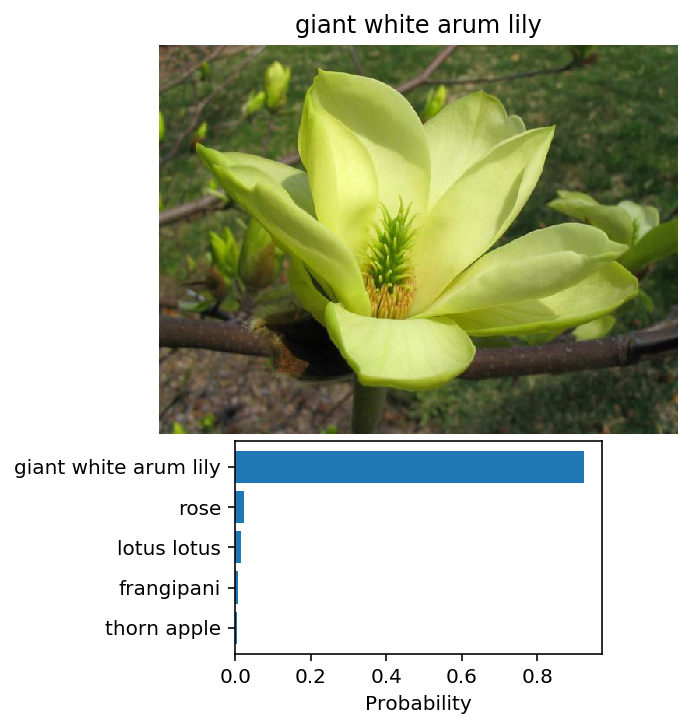

In [17]:
# TODO: Display an image along with the top 5 classes
image_path = test_dir + '/87/image_05462.jpg'
probabilitiess, classes = predict(image_path, model)
max_index = np.argmax(probabilities)
max_probability = probabilities[max_index]
label = classes[max_index]

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

image = Image.open(image_path)
ax1.axis('off')
ax1.set_title(cat_to_name[label])
ax1.imshow(image)
labels = []
for cl in classes:
    labels.append(cat_to_name[cl])
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()  # probabilities read top-to-bottom
ax2.set_xlabel('Probability')
ax2.barh(y_pos, probabilities, xerr=0, align='center')

plt.show()